In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import sys
import os
import matplotlib.pyplot as plt
from PIL import Image
import json

import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

In [ ]:
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    # !pip3 install timm==0.5.4

Running in Colab.


In [ ]:
from timm import create_model

model_name = "convnext_tiny"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

device =  cuda


In [ ]:
import os
import zipfile

# 데이터 경로
train_zip = '/content/drive/MyDrive/sushi_crop_data.zip'

zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/sushi_crop_data'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'valid')

In [ ]:
import os
import zipfile
import torch
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader

# IMAGENET 평균과 표준편차 정의
IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]

# learning rate와 batch size 정의
b_s = 16

# 데이터 경로
data_dir = '/tmp/sushi_crop_data_update'

# 데이터셋 준비
train_transforms = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
])

val_transforms = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
])

# ImageFolder를 사용하여 데이터셋 로드
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f'{data_dir}/valid', transform=val_transforms)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=val_transforms)

# DataLoader 생성 (num_workers를 2로 설정)
train_loader = DataLoader(train_dataset, batch_size=b_s, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=b_s, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=b_s, shuffle=False, num_workers=2)

# 클래스 이름과 라벨 확인
print('class name and label:')
for label, class_name in enumerate(train_dataset.classes):
    print(f'{label}. {class_name}')

print()
# 데이터셋 크기 출력
print(f'train dataset : {len(train_dataset)}')
print(f'valid dataset : {len(val_dataset)}')
print(f'test dataset  : {len(test_dataset)}')

class name and label:
0. arctic_surf_clam
1. capelin_roe
2. crab_meat
3. flatfish
4. fried_tofu_poouch
5. futomaki
6. octopus
7. salmon
8. shrimp
9. tamagoyaki
10. tilapia
11. tuna

train dataset : 5370
valid dataset : 578
test dataset  : 343


In [ ]:
# ConvNeXt 모델 로드 및 수정
model = create_model(model_name, pretrained=False, num_classes=len(train_dataset.classes))
model = model.to(device)

l_r = 1e-4

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=l_r)

# 학습과 검증 함수 정의
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 학습 및 검증 루프
num_epochs = 10
best_val_acc = 0.0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 최적의 검증 정확도를 가진 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'conv_best_model.pth')

# 테스트 데이터셋으로 최종 모델 평가
model.load_state_dict(torch.load('conv_best_model.pth'))
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 1/10
Train Loss: 1.6305, Train Accuracy: 0.4687
Validation Loss: 1.4756, Validation Accuracy: 0.5606
Epoch 2/10
Train Loss: 1.0430, Train Accuracy: 0.6698
Validation Loss: 1.0016, Validation Accuracy: 0.6990
Epoch 3/10
Train Loss: 0.7507, Train Accuracy: 0.7721
Validation Loss: 0.8226, Validation Accuracy: 0.7578
Epoch 4/10
Train Loss: 0.6257, Train Accuracy: 0.8080
Validation Loss: 0.8076, Validation Accuracy: 0.7595
Epoch 5/10
Train Loss: 0.5562, Train Accuracy: 0.8294
Validation Loss: 0.7689, Validation Accuracy: 0.7578
Epoch 6/10
Train Loss: 0.5044, Train Accuracy: 0.8454
Validation Loss: 0.6827, Validation Accuracy: 0.7924
Epoch 7/10
Train Loss: 0.4811, Train Accuracy: 0.8521
Validation Loss: 0.6881, Validation Accuracy: 0.7855
Epoch 8/10
Train Loss: 0.4359, Train Accuracy: 0.8665
Validation Loss: 0.6619, Validation Accuracy: 0.7958
Epoch 9/10
Train Loss: 0.4209, Train Accuracy: 0.8650
Validation Loss: 0.6974, Validation Accuracy: 0.7889
Epoch 10/10
Train Loss: 0.3859, Train

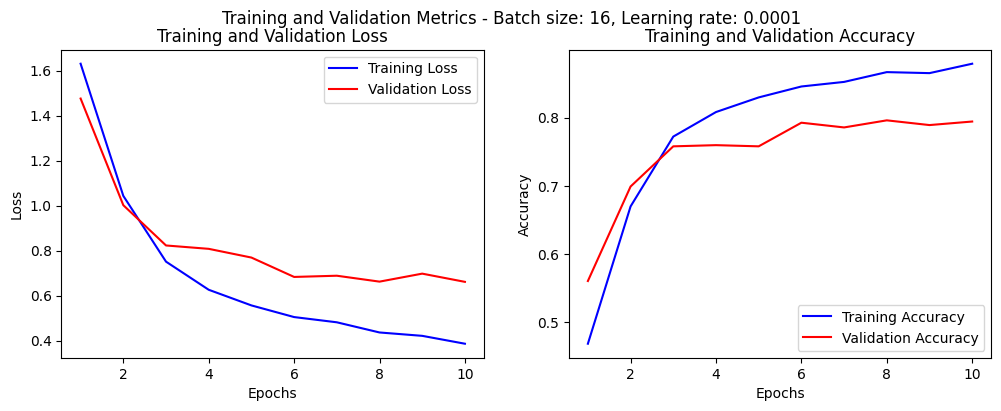

In [ ]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프 전체 제목에 Batch size와 Learning rate 추가
plt.suptitle(f'Training and Validation Metrics - Batch size: {b_s}, Learning rate: {l_r}')

plt.show()


Classification Report:
                    precision    recall  f1-score   support

 arctic_surf_clam       1.00      1.00      1.00        18
      capelin_roe       0.91      0.94      0.93        33
        crab_meat       0.93      0.90      0.91        29
         flatfish       0.40      0.35      0.38        17
fried_tofu_poouch       0.92      0.63      0.75        35
         futomaki       0.33      0.65      0.44        20
          octopus       0.68      0.75      0.71        28
           salmon       0.71      0.76      0.73        29
           shrimp       0.88      0.88      0.88        67
       tamagoyaki       0.68      0.68      0.68        28
          tilapia       0.85      0.55      0.67        20
             tuna       1.00      0.79      0.88        19

         accuracy                           0.77       343
        macro avg       0.77      0.74      0.75       343
     weighted avg       0.80      0.77      0.77       343



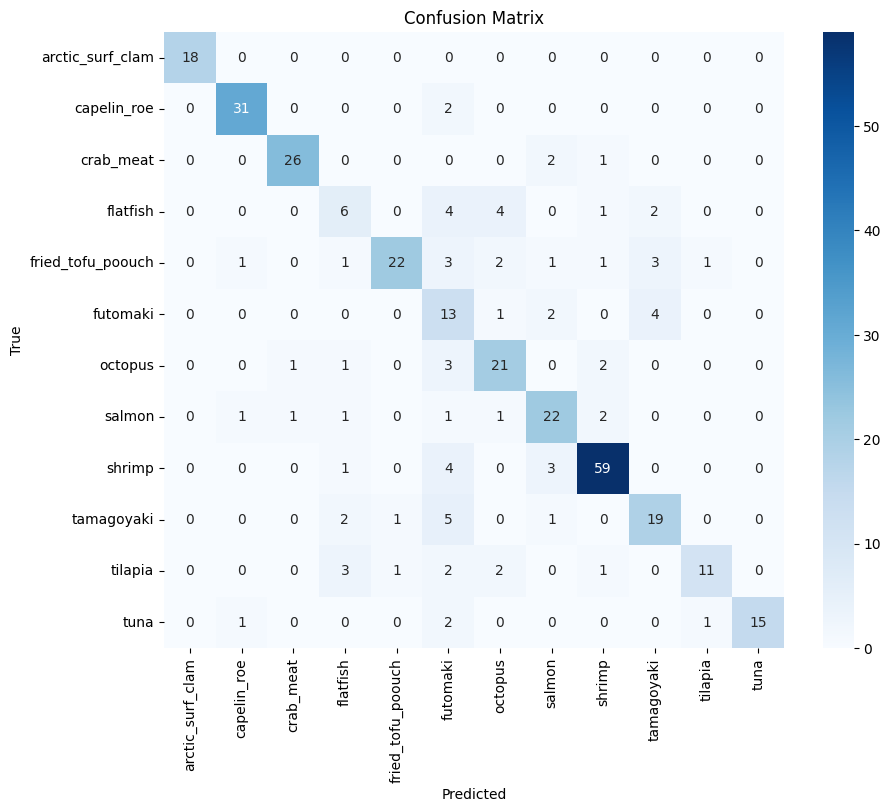

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬 및 분류 리포트 함수 정의
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# 혼동 행렬 및 분류 리포트 출력
labels, preds = evaluate_model(model, test_loader, device)
cm = confusion_matrix(labels, preds)
report = classification_report(labels, preds, target_names=train_dataset.classes)

print("Classification Report:\n", report)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install opencv-python

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.1 MB/

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import gradio as gr
from PIL import Image
import numpy as np

# 모델 로드
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_name = ['arctic_surf_clam', 'capelin_roe', 'crab_meat', 'flatfish', 'fried_tofu_pouch',
              'futomaki', 'octopus', 'salmon', 'shrimp', 'tamagoyaki', 'tilapia', 'tuna']
model_path = '/content/conv_best_model.pth'  # 모델 파일 경로

# ConvNeXt Tiny 모델 로드 및 수정
model = models.convnext_tiny(weights=None)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(class_name))  # 클래스 개수에 맞게 수정

# 엄격하지 않은 로드
state_dict = torch.load(model_path, map_location=device)
# 필요한 키만 추출하여 모델에 로드
model.load_state_dict({k: v for k, v in state_dict.items() if k in model.state_dict()}, strict=False)
model = model.to(device)
model.eval()

# 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(image):
    image = Image.fromarray(image)
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.softmax(outputs[0], dim=0).cpu().numpy()
        print(outputs)
        print(probabilities)
    return {f'class_{i}({class_name[i]})': float(probabilities[i]) for i in range(len(probabilities))}

# Gradio 인터페이스 설정
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy", label="Webcam Image"),
    outputs=gr.Label(num_top_classes=3),
    live=True,
    title="Multi-Label Classification with Resnet50",
    description="Made By Wasabi Warriors"
)

if __name__ == "__main__":
    interface.launch()

ModuleNotFoundError: No module named 'gradio'